In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Adding more information

Since results have not been good enough, data wil be filled with a little more information

In [12]:
movies = pd.read_csv('./datasets/peliculas.csv')
financials = pd.read_csv('./datasets/thenumbers.csv')
opening_gross = pd.read_csv('./datasets/opening_df.csv')
# this process had been already done, but now new columns will be added

In [15]:
num = (movies.dtypes == float) | (movies.dtypes == int)
num_cols = [i for i in num.index if num[i]]
movies_num = movies[num_cols]
financials = financials[['movie_title','production_budget','worldwide_gross']]
movies_num = pd.concat([movies_num,movies['movie_title']], axis=1)
movies_v2 = pd.merge(financials,movies_num, on= 'movie_title', how='left')

In [17]:
movies_v2 = movies_v2.drop('gross',axis=1).drop('duration.1',axis=1)
#this process has alredy been done on Data preparation

In [19]:
movies_v3 = pd.merge(opening_gross,movies_v2,on='movie_title',how='left')

In [30]:
movies_v3 = movies_v3.drop('Unnamed: 0',axis=1).drop('movie_title',axis=1)

In [32]:
from sklearn.impute import SimpleImputer as Imputer
imputer = Imputer(missing_values=np.nan, strategy='mean')

In [34]:
values = imputer.fit_transform(movies_v3)

In [35]:
X = pd.DataFrame(values)

In [36]:
X.columns = movies_v3.columns

In [38]:
X.index = movies_v3.index

In [44]:
X.to_csv('./intermediate_results/X_PLUS.csv')

In [46]:
y = X['worldwide_gross']
X = X.drop('worldwide_gross',axis=1)
# now there are more features that can give information to predict the worldwide_gross,
# the information now give was the amount of screen  were the movies were presented
# and the gross gotten on the first week of the movie

# Method evaluation

In [48]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

scores = cross_val_score(Lasso(),X,y,cv=5,scoring='r2')
scores
# using Lasso to make a cross validation 

array([0.73774447, 0.74140008, 0.79545382, 0.81606133, 0.63143067])

In [51]:
scores.mean()
# the mean of the scores gotten

0.7444180735484411

In [52]:
Lasso().fit(X_train,y_train).score(X_test,y_test)
#this is the new score when predicting the worldwide_gross, this could be improved

0.7940988733704553

# Selecting model (Applying Cross-Validation)

In [53]:
from sklearn.model_selection import cross_validate

In [54]:
results = cross_validate(Lasso(),X,y,return_train_score=True,cv=5)
results 

{'fit_time': array([0.02134442, 0.01591825, 0.00673676, 0.04171371, 0.04068279]),
 'score_time': array([0.00236988, 0.00275874, 0.00325656, 0.00212169, 0.00208092]),
 'test_score': array([0.73774447, 0.74140008, 0.79545382, 0.81606133, 0.63143067]),
 'train_score': array([0.75403753, 0.75450844, 0.74405841, 0.73100588, 0.78159958])}

In [55]:
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))
# comparing the the scores when the model is learning and when the model is predicting, let's change the method!

0.7530419676918244
0.7444180735484411


# Validation curve and Learning Curve

In [56]:
from sklearn.neighbors import KNeighborsRegressor as KNR
# KNR will be the new method to be applied

In [59]:
cross_validate(KNR(),X,y,cv=5,return_train_score=True) #applying KNR with the default number uf neighbors

{'fit_time': array([0.00529981, 0.00600934, 0.00400066, 0.00397968, 0.00397968]),
 'score_time': array([0.00743222, 0.00716043, 0.00619245, 0.00665331, 0.00689507]),
 'test_score': array([0.59821325, 0.62968738, 0.68181298, 0.79542433, 0.57510309]),
 'train_score': array([0.79328354, 0.77848631, 0.77796721, 0.75849495, 0.80916717])}

In [60]:
cross_validate(KNR(n_neighbors = 10),X,y,cv=5,return_train_score=True)#applying KNR with 10 number of neighbors

{'fit_time': array([0.00520515, 0.00452185, 0.0039947 , 0.00449109, 0.00401378]),
 'score_time': array([0.00814724, 0.00774074, 0.00741935, 0.00672865, 0.00662851]),
 'test_score': array([0.65306847, 0.64580186, 0.70176968, 0.79375629, 0.57312523]),
 'train_score': array([0.75370174, 0.75328266, 0.73155638, 0.71785447, 0.77263297])}

In [61]:
n=np.arange(2,50,2) # this will be the range where the number of neighbors will exist

In [62]:
from sklearn.model_selection import validation_curve

In [63]:
train_scores,test_scores = validation_curve(KNR(),
                                                X,
                                                y,
                                                param_name='n_neighbors',
                                                param_range=n,
                                                cv=5)
#applying the range of numbers of neighbors

In [64]:
np.mean(train_scores,axis=1) #applying the mean to the scores

array([0.87471454, 0.79824319, 0.77349671, 0.75626034, 0.74580565,
       0.73526339, 0.72552407, 0.71681661, 0.71173612, 0.7071404 ,
       0.70491619, 0.7006084 , 0.69706256, 0.69526317, 0.69234892,
       0.68897647, 0.68601135, 0.68303791, 0.67976695, 0.67648867,
       0.673862  , 0.67211224, 0.66950805, 0.66711713])

In [65]:
np.mean(test_scores,axis=1)

array([0.57784605, 0.64262706, 0.66423034, 0.6680601 , 0.67350431,
       0.67580262, 0.66972714, 0.66908447, 0.67108563, 0.67326752,
       0.67069467, 0.66968618, 0.66843397, 0.66619896, 0.66421786,
       0.66155192, 0.66066663, 0.66027601, 0.6583934 , 0.65623105,
       0.65512835, 0.65331188, 0.65230719, 0.65030315])

([<matplotlib.axis.XTick at 0x7fbc7f5d4828>,
 <a list of 24 Text xticklabel objects>)

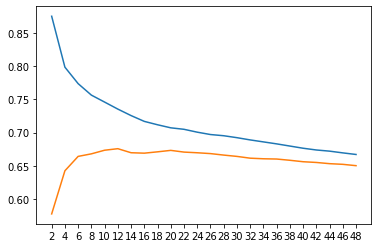

In [66]:
plt.plot(np.mean(train_scores,axis=1))
plt.plot(np.mean(test_scores,axis=1))
plt.xticks(np.arange(24),n)
# ploting the validation curve 

In [67]:
from sklearn.model_selection import learning_curve

In [68]:
samples ,train, test =learning_curve(KNR(n_neighbors=6),X,y,cv=5) # using learning curve function 

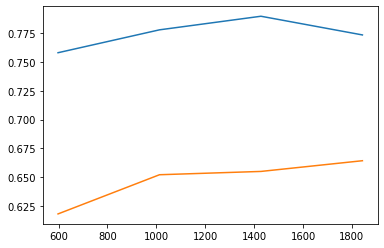

In [69]:
plt.plot(samples[1:],np.mean(train,axis=1)[1:])
plt.plot(samples[1:],np.mean(test,axis=1)[1:])
#ploting the mean of the learning of model KNR